## **Instalacion de dependencias**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### libreria Transformers de hugging face

In [ ]:
#!pip install -q pyyaml==5.1
## solución alternativa: instale la versión anterior de pytorch ya que detectron2 no ha lanzado paquetes para pytorch 1.9 (problema: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html --no-cache-dir

# instalar detectron2 que coincida con pytorch 1.8
# Consulte https://detectron2.readthedocs.io/tutorials/install.html para obtener instrucciones
#!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'


In [ ]:
pip install transformers datasets

In [ ]:
!apt update -y
!apt install -y tesseract-ocr
!pip install -q pytesseract

In [ ]:
pip install pandas matplotlib sklearn

In [ ]:
!pip install sentencepiece

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets import (Array2D, Array3D, ClassLabel, Dataset, Features,
                      Sequence, Value)
from PIL import Image
from sklearn.model_selection import train_test_split 
from tqdm import tqdm
import sentencepiece
from transformers import (AdamW, LayoutLMv2FeatureExtractor,
                          LayoutLMv2ForSequenceClassification,
                          LayoutLMv2Processor, LayoutLMv2Tokenizer,LayoutXLMTokenizer, LayoutXLMProcessor)


import pytesseract
import json

## Data
La data esta en una carpeta en el drive


In [2]:
def count_exp(path):
    c = {}
    for expression in os.listdir(path)[:-1]:
        class_path = os.path.join(path, expression)
        c[expression] = len(os.listdir(class_path))
    df = pd.DataFrame(c, index=["count"],dtype='object')
    return df

      Biologia CienciasSalud CienciasSociales MatematicasEstadistica Quimica
count       30            28               29                     29      29


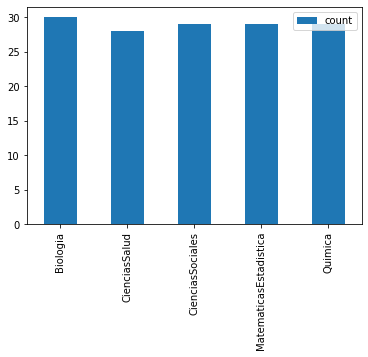

In [3]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/LayoutMXL/data/train"
count = count_exp(dataset_path)
print(count)
count.transpose().plot(kind='bar');

### Preprocesamiento del dataset 
Convertimos el conjunto de datos en un marco de datos de Pandas, que tiene 2 columnas: image_path y label.

In [4]:
data=pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/LayoutMXL/data/train/dataseTrain.pkl')
data.head(2)

,label,path,words,boxes
0,Quimica,/content/drive/MyDrive/Colab Notebooks/LayoutM...,"[Sharon, Eliana, Villamil-Silva',, Lesly, Joha...","[[176, 64, 219, 75], [220, 63, 258, 75], [257,..."
1,Quimica,/content/drive/MyDrive/Colab Notebooks/LayoutM...,"[Sergio, Acevedo',, Liliana, Giraldo', &., Jua...","[[264, 63, 305, 78], [304, 64, 370, 76], [369,..."


In [5]:
labels_unique = list(set(data['label']))
labels= list(data['label'])
id2label = {v: k for v, k in enumerate(labels_unique)}
label2id = {k: v for v, k in enumerate(labels_unique)}


In [6]:
id2label

{0: 'CienciasSociales',
 1: 'MatematicasEstadistica',
 2: 'CienciasSalud',
 3: 'Biologia',
 4: 'Quimica'}

In [7]:
out_file = open("/content/drive/MyDrive/Colab Notebooks/LayoutMXL/models/complementos/id2l.json", "w") 
    
json.dump(id2label, out_file, indent = 6) 
    
out_file.close() 

In [8]:
data.shape

(145, 4)

In [9]:
train_df, test_df = train_test_split(data, test_size=(0.3), shuffle=True,stratify=data['label'])

print(f"Train Len:: {len(train_df)}\tTest Len:: {len(test_df)}")

Train Len:: 101	Test Len:: 44


In [10]:
train_df.label.value_counts()

Biologia                  21
CienciasSalud             20
CienciasSociales          20
Quimica                   20
MatematicasEstadistica    20
Name: label, dtype: int64

In [11]:
test_df.label.value_counts()

Quimica                   9
MatematicasEstadistica    9
Biologia                  9
CienciasSociales          9
CienciasSalud             8
Name: label, dtype: int64

In [12]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [13]:
#processor = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base", revision="no_ocr")
feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr = False)
tokenizer =  LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")
processor = LayoutXLMProcessor(feature_extractor, tokenizer)

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels_unique), names=labels_unique),
})

In [14]:
def preprocess_data(examples):
  # tomar un batch de imágenes
  image = images = [Image.open(path).convert("RGB") for path in examples['path']]
  words = examples['words']
  boxes = examples['boxes']  # make sure to normalize your bounding boxes  
  encoded_inputs = processor(image, words, boxes=boxes, padding="max_length", truncation=True, max_length=512, return_token_type_ids=True)
  #encoded_inputs = processor(images, padding="max_length", truncation=True, max_length=512, return_token_type_ids=True)
  
  # agregamos labels
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]

  return encoded_inputs

print("\nEncoding Dataset")
train_encoded_data = train_dataset.map(preprocess_data, remove_columns=train_dataset.column_names, features=features, batched=True)
test_encoded_data = test_dataset.map(preprocess_data, remove_columns=test_dataset.column_names, features=features, batched=True)


Encoding Dataset


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

A continuación, establecemos el formato en tensores PyTorch. También especificamos poner todo en la GPU (CUDA).

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
train_encoded_data.set_format(type="torch", device=device)
test_encoded_data.set_format(type="torch", device=device)

Ahora podemos crear un dataloader PyTorch

In [17]:
train_dataloader = torch.utils.data.DataLoader(train_encoded_data, batch_size=3, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_encoded_data, batch_size=3)
#batch = next(iter(dataloader))

### Definimos el modelo 
Aquí definimos el modelo, a saber, LayoutLMv2ForSequenceClassification. Lo inicializamos con los pesos del modelo base pre-entrenado (LayoutLMModel). Los pesos del cabezal de clasificación se inicializan aleatoriamente y se ajustarán junto con los pesos del modelo base en nuestro pequeño conjunto de datos. Una vez cargado, lo trasladamos a la GPU.

In [18]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutxlm-base", 
                                                            num_labels=len(labels))
model.to(device)
print("terminado")

Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.stem.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv2.norm.num_batches_tracked', 'la

terminado


### Train the model
Aquí entrenamos al modelo en la forma familiar de PyTorch. Usamos el optimizador de Adam con corrección de disminución de peso (normalmente, también puede especificar qué variables deberían tener disminución de peso y cuáles no + un programador de tasa de aprendizaje, vea aquí cómo lo hicieron los autores de LayoutLM) y entrenamos durante 30 épocas. Si el modelo puede sobreajustarlo, significa que no hay problemas y podemos entrenarlo en todo el conjunto de datos.

In [19]:
def train(model, dataloader, optimizer):
    model.train()
    pbar = tqdm(dataloader)
    correct = 0
    total_loss = 0
    progress = 0
    for batch_idx, batch in enumerate(pbar):

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        predictions = outputs.logits.argmax(-1)
        correct += (predictions == batch['labels']).float().sum()
        total_loss += loss.item()
        progress += batch["input_ids"].shape[0]

        pbar.set_description(
            desc=f'batch_id={batch_idx} loss={total_loss / (batch_idx+1):.4f} acc={100 * correct / progress:.2f} %')


def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    iteration = 0
    with torch.no_grad():
        for batch in dataloader:
            # forward pass
            outputs = model(**batch)
            loss = outputs.loss

            total_loss += loss.item()
            predictions = outputs.logits.argmax(-1)
            correct += (predictions == batch['labels']).float().sum() 
            iteration += 1  

    accuracy = 100 * correct / len(dataloader.dataset)
    print("loss: {:.4f} \t Accuracy: {:.2f} %\n".format(
        total_loss / iteration, accuracy.item()))

In [20]:
epochs=5
optimizer = AdamW(model.parameters(), lr=5e-5)
for epoch in range(epochs):
    print("Epoch: ",epoch)

    train(model, train_dataloader, optimizer)
    evaluate(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:  0


batch_id=33 loss=1.8093 acc=44.55 %: 100%|██████████| 34/34 [00:25<00:00,  1.32it/s]


loss: 0.8647 	 Accuracy: 68.18 %

Epoch:  1


batch_id=33 loss=0.4914 acc=83.17 %: 100%|██████████| 34/34 [00:26<00:00,  1.29it/s]


loss: 0.2879 	 Accuracy: 88.64 %

Epoch:  2


batch_id=33 loss=0.0824 acc=98.02 %: 100%|██████████| 34/34 [00:27<00:00,  1.25it/s]


loss: 0.2212 	 Accuracy: 90.91 %

Epoch:  3


batch_id=33 loss=0.0238 acc=100.00 %: 100%|██████████| 34/34 [00:27<00:00,  1.22it/s]


loss: 0.1082 	 Accuracy: 97.73 %

Epoch:  4


batch_id=33 loss=0.0077 acc=100.00 %: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s]


loss: 0.1202 	 Accuracy: 95.45 %



In [21]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/LayoutMXL/models')